---

# Predicting Loan Default with Random Forests

In this notebook, we will use a Random Forest classifier to predict whether a loan applicant is likely to default, using financial and demographic data from the Lending Club loan dataset. Random forests are an ensemble method that constructs multiple decision trees during training and outputs the majority vote of the individual trees. They tend to outperform single decision trees by reducing overfitting and improving generalization.

The dataset includes features such as loan amount, interest rate, FICO score, employment length, and purpose of the loan. The target variable is a binary label indicating whether the loan was Fully Paid or Charged Off. After preprocessing the data, we will train a random forest, evaluate its classification performance, and analyze feature importance to understand which factors most influence default risk.

---

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import kagglehub

# Download latest version
path = kagglehub.dataset_download("wordsforthewise/lending-club")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\kylej\.cache\kagglehub\datasets\wordsforthewise\lending-club\versions\3


---

Import and clean the data.

---

In [14]:
# Load a filtered subset of Lending Club data
df = pd.read_csv("accepted_2007_to_2018Q4.csv", low_memory=False)

# Keep only relevant and clean columns
df = df[['loan_amnt', 'term', 'int_rate', 'emp_length', 'home_ownership',
         'annual_inc', 'purpose', 'addr_state', 'dti', 'fico_range_high',
         'open_acc', 'revol_util', 'loan_status']]

# Drop rows with missing values
df.dropna(inplace=True)
df

,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,fico_range_high,open_acc,revol_util,loan_status
0,3600.0,36 months,13.99,10+ years,MORTGAGE,55000.0,debt_consolidation,PA,5.91,679.0,7.0,29.7,Fully Paid
1,24700.0,36 months,11.99,10+ years,MORTGAGE,65000.0,small_business,SD,16.06,719.0,22.0,19.2,Fully Paid
2,20000.0,60 months,10.78,10+ years,MORTGAGE,63000.0,home_improvement,IL,10.78,699.0,6.0,56.2,Fully Paid
3,35000.0,60 months,14.85,10+ years,MORTGAGE,110000.0,debt_consolidation,NJ,17.06,789.0,13.0,11.6,Current
4,10400.0,60 months,22.45,3 years,MORTGAGE,104433.0,major_purchase,PA,25.37,699.0,12.0,64.5,Fully Paid
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260694,24000.0,60 months,12.79,7 years,MORTGAGE,95000.0,home_improvement,AL,19.61,669.0,5.0,84.4,Current
2260695,24000.0,60 months,10.49,10+ years,MORTGAGE,108000.0,debt_consolidation,UT,34.94,699.0,24.0,39.0,Current
2260696,40000.0,60 months,10.49,9 years,MORTGAGE,227000.0,debt_consolidation,CA,12.75,709.0,5.0,64.9,Current
2260697,24000.0,60 months,14.49,6 years,RENT,110000.0,debt_consolidation,FL,18.30,664.0,10.0,68.1,Charged Off


---

Remove empty data.

---

In [15]:
# Keep only loans that are either fully paid or charged off
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
df['default'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})
df.drop(columns='loan_status', inplace=True)

C:\Users\kylej\AppData\Local\Temp\ipykernel_48856\1827625857.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['default'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})
C:\Users\kylej\AppData\Local\Temp\ipykernel_48856\1827625857.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='loan_status', inplace=True)


---

Encode labels for our feature vectors.

---

In [16]:
for col in ['term', 'emp_length', 'home_ownership', 'purpose', 'addr_state']:
    df[col] = LabelEncoder().fit_transform(df[col])

C:\Users\kylej\AppData\Local\Temp\ipykernel_48856\2115353809.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = LabelEncoder().fit_transform(df[col])
C:\Users\kylej\AppData\Local\Temp\ipykernel_48856\2115353809.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = LabelEncoder().fit_transform(df[col])
C:\Users\kylej\AppData\Local\Temp\ipykernel_48856\2115353809.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

---

Separate our test and training sets.

---

In [17]:
X = df.drop(columns='default')
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

---

We can now train our random forest! Here, we choose 100 estimators with a maximum depth of 10 to balance training time, overfitting risk, and accuracy.

---

In [18]:
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

---

We now test our random forest and print the confusion matrix.

---

Accuracy: 80.64%

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.99      0.89    203744
           1       0.57      0.03      0.06     49452

    accuracy                           0.81    253196
   macro avg       0.69      0.51      0.48    253196
weighted avg       0.76      0.81      0.73    253196



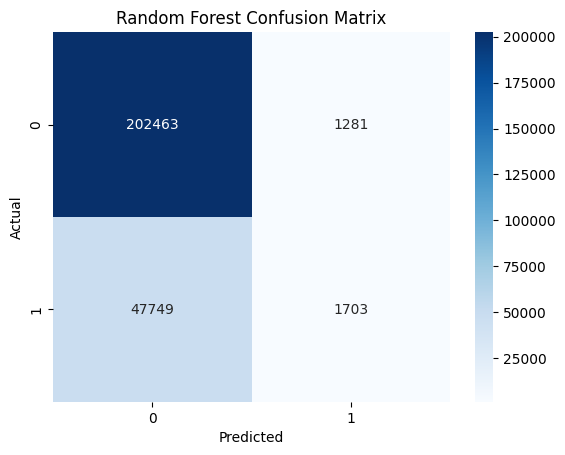

In [19]:
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

---

As we can see, the random forest performed slightly better than a decision tree on the same dataset. This is likely because the data was not complex enough for the additional effort of a decision tree to yield substantially more accurate results. However, for even denser and more messy datasets, decision trees can prove even more useful for filtering signal from noise. We can also go ahead and plot the features importances to see what the model valued most.

---

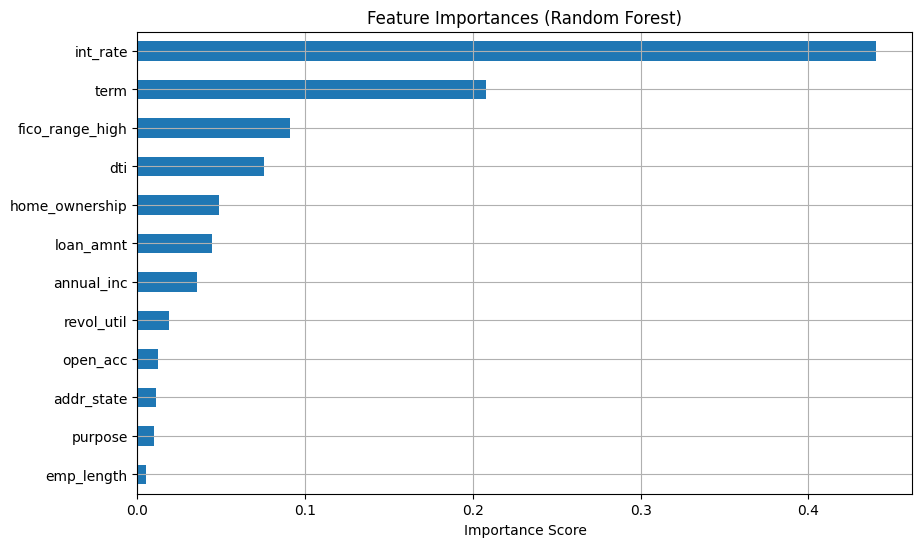

In [20]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.grid(True)
plt.show()

---

The model indicates that the interest rate is by-far the biggest predictor of loan default, which tracks with our intuition in this case. This illustrates the potential for random forests to be applied to real-world scenarios, such as banks hoping to reduce their overall risk by determining what to look out for when lending.

---